# Ingredients Prediction

* In this notebook we are going to build a model that will try to predict how many ingredients a  
pizza shop is going to use in a given week, wich will help them prepare their stock with enough antelation

* The idea is to first try to predict the ingredient distriution of a given day, based on data of the past,  
and then sum up all the predictions of one week

* Once we have a model that fits the time series decently, we'll a constant that will make the prediction allways  
above the real value, because it is preferable to have leftovers than lack of stock

## Import Libraries

In [8]:
import pandas as pd
import json
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

## Load Data

In [9]:
ingredients = pd.read_csv('data/ingredients_per_day_2015.csv', index_col=0)
ingredients.index = pd.to_datetime(ingredients.index)
'''Sort the data by date'''
ingredients = ingredients.sort_index()
ingredients.head()

,Alfredo Sauce,Anchovies,Artichoke,Arugula,Asiago Cheese,Bacon,Barbecue Sauce,Barbecued Chicken,Beef Chuck Roast,Blue Cheese,...,Romano Cheese,Sliced Ham,Smoked Gouda Cheese,Soppressata Salami,Spinach,Sun-dried Tomatoes,Thai Sweet Chilli Sauce,Thyme,Tomatoes,Zucchini
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,3,4,43,9,18,24,27,27,8,21,...,21,7,21,3,60,11,22,0,227,7
2015-01-02,2,14,69,9,24,19,19,19,14,18,...,18,21,18,12,61,7,19,0,220,21
2015-01-03,13,11,67,12,30,18,16,16,21,12,...,12,18,12,3,78,19,23,1,195,23
2015-01-04,9,10,49,9,19,11,27,27,6,12,...,12,7,12,0,40,6,13,2,132,8
2015-01-05,19,10,46,8,34,19,5,5,4,18,...,18,9,18,3,54,14,14,2,128,8


### Fill Missing Days with previous day

In [10]:
dates = pd.date_range(ingredients.index[0], ingredients.index[-1])
ingredients = ingredients.reindex(dates, method='ffill')

## Prepare Data for Training

We are going to predict the ingredients spent on a given day using the mean of the $d$ inmediate previous days  
and the $w$ same days of the previous w weeks.  
Ej. If we are trying to predict the ingredients of 2015-12-31 we are going to take the mean of the following days ($d=3,w=2$): 
 - 2015-12-30
 - 2015-12-29
 - 2015-12-28
 - 2015-12-24
 - 2015-12-17  

And that is going to be the input to our model, which will output another distribution of ingredients, which is the prediction we are looking for.  

In [11]:
def mean_ingredients_train(day,previous_days=3,previous_weeks=2,verbose=False):
    '''
    Returns the mean of the ingredients of the previous days and the same day of the previous weeks
    '''
    if verbose:
        print('Mean ingredients to train Day: ',day.date())
    last_day = day-pd.Timedelta(days=1)
    pdays = ingredients[day-pd.Timedelta(days=previous_days):last_day]
    if len(pdays) < previous_days and verbose:
        print('Missing data for previous days, expected {} days, got {}'.format(previous_days,len(pdays)))
    for w in range(1,previous_weeks+1):
        date = day-pd.Timedelta(weeks=w)
        if date in ingredients.index:
            pdays = pd.concat([pdays,ingredients[date:date]])
        elif verbose:
            print('Missing data of previous week',date.date())
    if verbose:
        print("Days used for predicting",[str(d.date()) for d in pdays.index])
    if len(pdays) == 0:
        if verbose:
            print('No data available, using mean of all data')
        return ingredients.mean()
    return pdays.mean()

mean_ingredients_train(pd.to_datetime('2015-12-31'))

Alfredo Sauce                3.8
Anchovies                    5.8
Artichoke                   37.2
Arugula                      6.4
Asiago Cheese               12.2
                           ...  
Sun-dried Tomatoes          11.6
Thai Sweet Chilli Sauce     13.8
Thyme                        0.8
Tomatoes                   112.4
Zucchini                     9.8
Length: 64, dtype: float64

In [12]:
X = []
y = []
PREVIOUS_DAYS=2
PREVIOUS_WEEKS=4
for day in ingredients.index:
    X.append(mean_ingredients_train(day,previous_days=PREVIOUS_DAYS,previous_weeks=PREVIOUS_WEEKS))
    y.append(ingredients.loc[day])
# Apend the day of the week and the month as features
X = pd.DataFrame(X,index=ingredients.index)
X['dayofweek'] = X.index.dayofweek
X['month'] = X.index.month
y = pd.DataFrame(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train Data

I opted to use XGBoost, to perform the Regression needed to predict the distribution of ingredients of a given day

In [13]:
model = xgb.XGBRegressor(
    objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,   
    max_depth = 5, alpha = 10, n_estimators = 200
)

model.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

## Testing

* As you can see we get a mean absolute error of 6.66.  
* This means that our model fails to predict the ingredient ditribution with a mean margin of 6.66

In [14]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
maes=abs(y_test-y_pred).mean()
print('Mean squared error: ',mse)
print('Mean absolute error: ',mae)
print('Mean absolute error of each ingredient:')

Mean squared error:  115.25394828558882
Mean absolute error:  6.69191606162269
Mean absolute error of each ingredient:


In [15]:
'''Save the model'''
save=False
if save:
    model.save_model('model/ingredients.model')
    model_info = {
        "mse":mse,
        "mae":mae,
        "maes":maes.to_dict(),
        "previous_days":PREVIOUS_DAYS,
        "previous_weeks":PREVIOUS_WEEKS,
        "alpha":0.5,
    }
    json.dump(model_info,open('model/info.json','w'))

In [16]:
'''Load the model'''
model = xgb.XGBRegressor()
model.load_model('model/ingredients.model')
model_info = json.load(open('model/info.json','r'))

## Predict

* We want our model to be realistic, and that means predicting data of a given week with enough antelation.  
* So we are going to be missing some data between the day we want to know the stock and that week
* To fix that, out prediction is going to be recurrent. That is, we'll also predict the data required to predict  
the week

In [17]:
def mean_ingredients_predict(day,previous_days=3,previous_weeks=2,verbose=False,dataframe=None):
    '''
    Returns the mean of the ingredients of the previous days and the same day of the previous weeks to
    use as input for the model
    '''
    if verbose:
        print('Mean ingredients to train Day: ',day.date())
    start_day = day-pd.Timedelta(days=previous_days)
    last_day = day-pd.Timedelta(days=1)
    pdays = pd.date_range(start_day,last_day)
    '''Append previous weeks'''
    for w in range(previous_weeks,0,-1):
        date = day-pd.Timedelta(weeks=w)
        pdays = pdays.insert(previous_weeks-w,date)
    '''Fill missing data'''
    for day in pdays:
        if day not in dataframe.index:
            if verbose:
                print('Missing previous day:',day.date())
            delta=day-dataframe.index[0]
            if verbose:
                print("Attempting to predict it")
            if delta.days < previous_weeks*7:
                if verbose:
                    print('Not enough data to predict!')
                    print('Returning mean of previous and next days')
                m=1
                try:
                    return (dataframe.loc[day-pd.Timedelta(days=m)]+dataframe.loc[day+pd.Timedelta(days=m)])/(2*m)
                except:
                    if verbose:
                        print('To enought data to calculate mean')
                        print("Returning mean of all data")
                    return dataframe.mean()
            dataframe.loc[day] = predict(day)
    return dataframe.loc[pdays].mean()

def predict(day,verbose=False,dataframe=None):
    '''
    Predict the ingredients for the given day
    Inputs:
        day: datetime object
        verbose: bool
        dataframe: dataframe with the ingredients
    Outputs:
        ingredients: dataframe with the ingredients
    '''
    if dataframe is None:
        dataframe = ingredients
    mean = mean_ingredients_predict(day,verbose=verbose,dataframe=dataframe,previous_days=PREVIOUS_DAYS,previous_weeks=PREVIOUS_WEEKS)
    dayofweek = day.dayofweek
    month = day.month
    X = pd.DataFrame([mean],columns=mean.index)
    X['dayofweek'] = dayofweek
    X['month'] = month
    pred = model.predict(X).tolist()[0]
    return pd.Series(pred,index=mean.index)
predict(pd.to_datetime('2016-01-07'),verbose=True)

Mean ingredients to train Day:  2016-01-07
Missing previous day: 2016-01-05
Attempting to predict it
Missing previous day: 2016-01-06
Attempting to predict it


Alfredo Sauce                4.895248
Anchovies                    9.812974
Artichoke                   48.969646
Arugula                      9.421505
Asiago Cheese               16.585260
                              ...    
Sun-dried Tomatoes          10.085375
Thai Sweet Chilli Sauce     14.123583
Thyme                        1.545438
Tomatoes                   149.958588
Zucchini                    13.310370
Length: 64, dtype: float64

## Visualizations

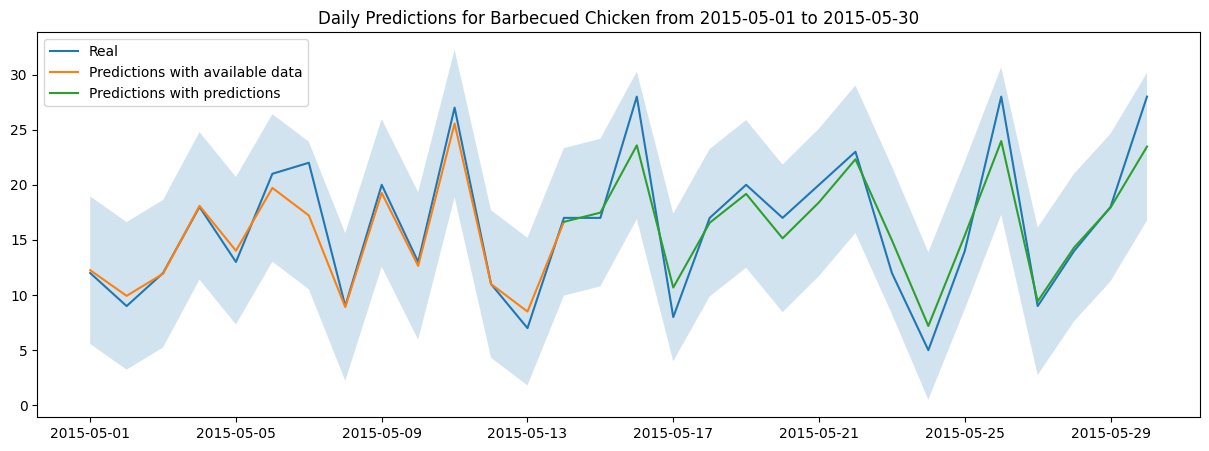

In [18]:
ingredient = 'Barbecued Chicken'
start_prediction = pd.to_datetime('2015-05-01')
end_prediction = pd.to_datetime('2015-05-30')
start_data = pd.to_datetime('2015-03-01')
end_data = pd.to_datetime('2015-05-14')
available_data = ingredients.loc[start_data:end_data].copy()
preds = []
for day in pd.date_range(start_prediction,end_prediction):
    preds.append(predict(day,verbose=False,dataframe=available_data)[ingredient])
preds = pd.Series(preds,index=pd.date_range(start_prediction,end_prediction))
plt.figure(figsize=(15,5))
'''Real Data'''
intersection = pd.date_range(start_prediction,end_prediction).intersection(ingredients.index)
plt.plot(ingredients.loc[intersection,ingredient],label='Real')
'''Predictions from start_data to end_data'''
dates = pd.date_range(start_data,end_data).intersection(pd.date_range(start_prediction,end_prediction))
plt.plot(preds.loc[dates],label='Predictions with available data')
'''Predictions from end_data to end_prediction'''
plt.plot(preds.loc[pd.date_range(end_data,end_prediction)],label='Predictions with predictions')
plt.legend()
'''Area surrounded by the predictions with margin the mean absolute error'''
plt.fill_between(preds.index,preds-mae,preds+mae,alpha=0.2)
plt.title(f'Daily Predictions for {ingredient} from {start_prediction.date()} to {end_prediction.date()}');

## Predict Stock for given Week

* Now we just have to use out model to sum up all values predicted for the given week, increasing the prediction  
of each day by the margin of each ingredient (or the MAE, 6.66) to try to never run out of stock.  
* Using the MAE of each ingredient as margin is more accurate, because each ingredient has its own scale. For  
example, the number of tomatoe used each day is in the order of 1000, so it is intuitive that a wider margin  
should be used in this case.

In [19]:
def predict_stock(monday,margins=None,verbose=False,dataframe=None):
    '''
    Predict the stock for the given week, summing up the ingredients for each day
    Returns: DataFrame with the predicted stock for each ingredient
    '''
    if dataframe is None:
        dataframe = ingredients.copy()
    if margins is None:
        margins = 0
    stock = predict(monday,verbose=verbose,dataframe=dataframe)+margins
    for day in pd.date_range(monday+pd.Timedelta(days=1),monday+pd.Timedelta(days=6)):
        stock += predict(day,verbose=verbose,dataframe=dataframe)+margins
    return stock

def real_stock(monday,dataframe=None):
    '''
    Returns the real stock for the given week
    '''
    if dataframe is None:
        dataframe = ingredients.copy()
    stock = dataframe.loc[monday]
    for day in pd.date_range(monday+pd.Timedelta(days=1),monday+pd.Timedelta(days=6)):
        stock += dataframe.loc[day]
    return stock

dataframe = ingredients[:pd.to_datetime('2015-04-29')].copy()
margins = pd.Series(model_info["maes"],index=ingredients.columns)
predict_stock(pd.to_datetime('2015-05-04'),margins=margins,dataframe=dataframe)

Alfredo Sauce                60.324144
Anchovies                    86.369013
Artichoke                   460.271442
Arugula                      67.223878
Asiago Cheese               192.071691
                              ...     
Sun-dried Tomatoes          120.118608
Thai Sweet Chilli Sauce     137.304774
Thyme                        18.746703
Tomatoes                   1337.395540
Zucchini                    132.267416
Length: 64, dtype: float64

In [20]:
real_stock(pd.to_datetime('2015-05-04'))

Alfredo Sauce                40.0
Anchovies                    54.0
Artichoke                   398.0
Arugula                      35.0
Asiago Cheese               130.0
                            ...  
Sun-dried Tomatoes           95.0
Thai Sweet Chilli Sauce     100.0
Thyme                        12.0
Tomatoes                   1140.0
Zucchini                     98.0
Name: 2015-05-04 00:00:00, Length: 64, dtype: float64

## Visualizations 2

* Now lets visualize how our model really works.
* We'll plot our model prediction of the given ingredients for each week in 2015, using data according to given antelation,  
thus making it more realistic
* For example, with $antelation=4$, to predict the distribution of the week starting on 2015-12-28, we'll use data until 2015-12-23, simulating that we are using this model the previuos Thursday
* Another parameter, $alpha$ is given, to tune how much the margin affects the prediction

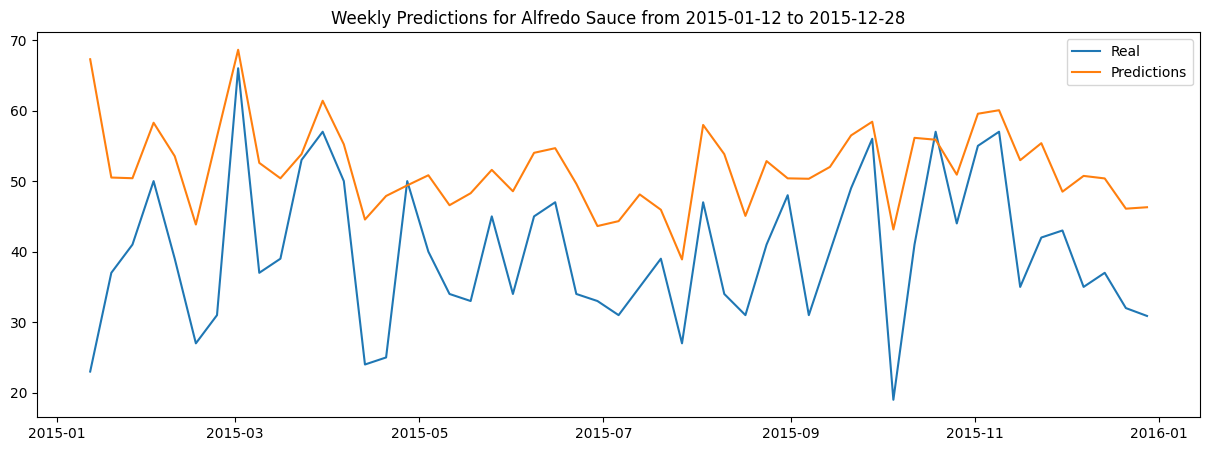

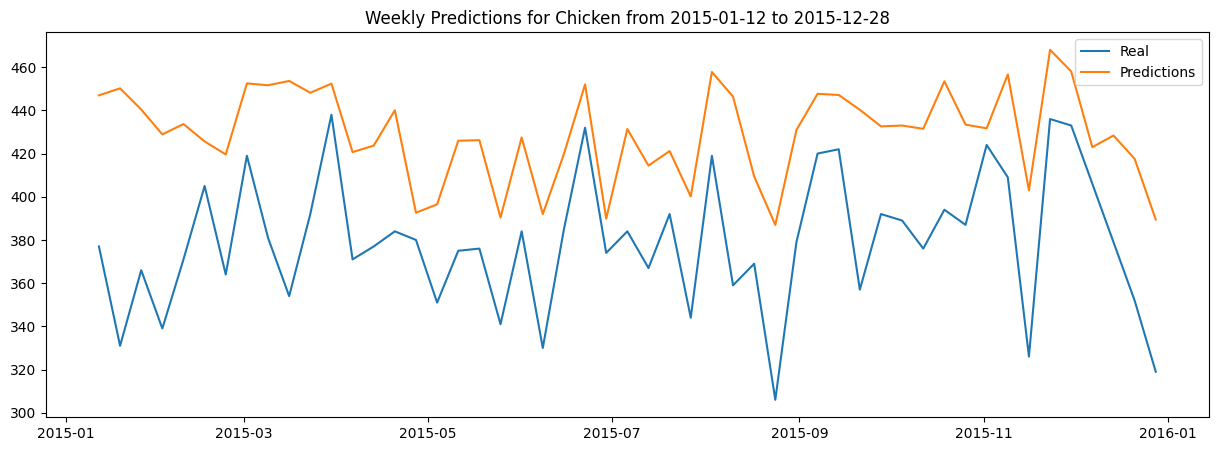

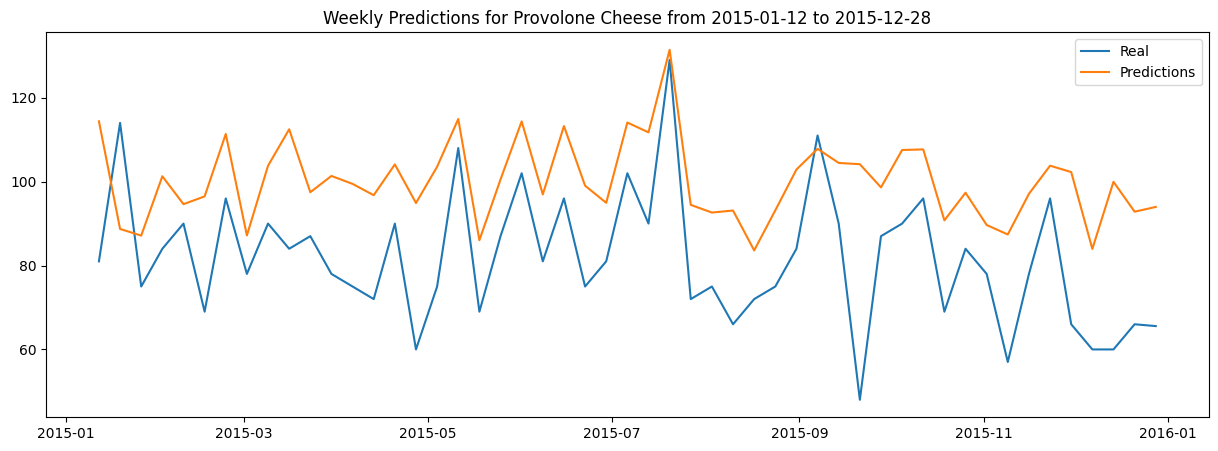

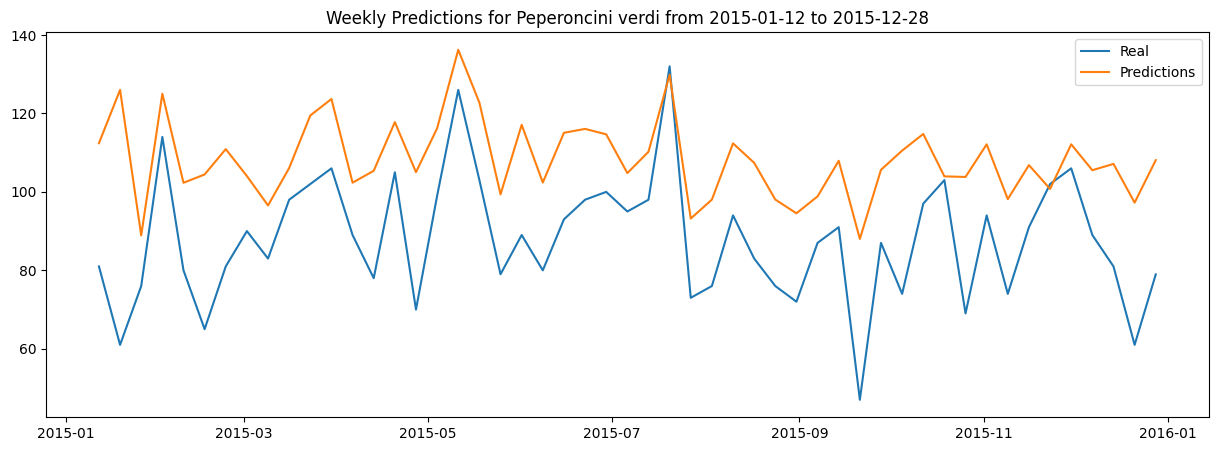

In [21]:
antelation = 4
alpha=0.5
ings=['Alfredo Sauce','Chicken','Provolone Cheese','Peperoncini verdi']
start_prediction = pd.to_datetime('2015-01-12')
end_prediction = pd.to_datetime('2015-12-28')
for ingredient in ings:
    predictions = []
    for monday in pd.date_range(start_prediction,end_prediction,freq='W-MON'):
        dataframe = ingredients[:monday-pd.Timedelta(days=antelation)].copy()
        predictions.append(predict_stock(monday,margins=maes*alpha,verbose=False,dataframe=dataframe)[ingredient])
    predictions = pd.Series(predictions,index=pd.date_range(start_prediction,end_prediction,freq='W-MON'))
    plt.figure(figsize=(15,5))
    '''Real Data'''
    real = []
    for monday in pd.date_range(start_prediction,end_prediction,freq='W-MON'):
        count = 0
        for day in pd.date_range(monday,monday+pd.Timedelta(days=6)):
            count += ingredients.loc[day,ingredient]
        real.append(count)
    real = pd.Series(real,index=pd.date_range(start_prediction,end_prediction,freq='W-MON'))
    plt.plot(real,label='Real')
    '''Predictions'''
    plt.plot(predictions,label='Predictions')
    plt.legend()
    plt.title(f'Weekly Predictions for {ingredient} from {start_prediction.date()} to {end_prediction.date()}');
    plt.show()